# Modelado de los datos

En esta fase del proyecto aplicaré algoritmos de reglas de asociación para descubrir patrones de co-ocurrencia entre productos, a partir del historial de transacciones disponible en el conjunto de datos.

Con el objetivo de evaluar el impacto que tiene la selección del conjunto de datos en la calidad de las reglas generadas, se construirán **dos modelos diferentes**, aplicando el mismo algoritmo de análisis pero sobre datasets distintos:

- **Modelo 1**: Entrenado exclusivamente con las transacciones realizadas en `United Kingdom`, el país con mayor volumen de datos. Este enfoque prioriza la consistencia y la estabilidad estadística.

- **Modelo 2**: Entrenado con un subconjunto más diverso, que incluye únicamente aquellos países con suficiente volumen de transacciones o con un comportamiento destacado (por ejemplo, alto gasto medio por factura). Este enfoque busca generar reglas más variadas y representativas de un entorno internacional.

Ambos modelos se evaluarán comparando la calidad de las reglas generadas, considerando métricas como el **soporte**, la **confianza** y el **lift**. Esto me permitirá determinar qué conjunto de datos produce reglas más relevantes, interpretables y útiles para el negocio.

# Modelos de co-ocurrencia

Los modelos de co-ocurrencia permiten identificar patrones de compra frecuentes entre productos, a partir del análisis de las cestas de la compra (transacciones). Su objetivo es encontrar combinaciones de productos que suelen aparecer juntas, para generar **reglas de asociación** como:

> "Los clientes que compran el producto A, también tienden a comprar el producto B".

Este tipo de modelos se basa en observar **la presencia conjunta** de productos en una misma transacción, sin tener en cuenta el orden ni el tiempo. Por eso se conocen también como **modelos de reglas de asociación**. **¿Qué hacen estos modelos?**

- Analizan una **matriz binaria** de transacciones y productos (1 = comprado, 0 = no comprado).

- Detectan **conjuntos de productos frecuentes** que superan un umbral mínimo de aparición.

- A partir de esos conjuntos, generan reglas que describen **relaciones condicionales** entre productos.

Si muchas transacciones contienen tanto "Vela" como "Portavelas", el modelo puede generar una regla. Por ejemplo: `Vela → Portavelas` indicando que comprar velas suele implicar también la compra de portavelas.

**Tipos de modelos de co-ocurrencia**

Existen diferentes formas de detectar productos que suelen comprarse juntos. A continuación se resumen los principales enfoques:

- **Apriori**: modelo clásico basado en combinaciones de productos frecuentes. Genera reglas claras y fáciles de interpretar.

- **FP-Growth**: alternativa más eficiente al Apriori, ideal para grandes volúmenes de datos.

- **Matriz de co-ocurrencia**: cuenta directamente cuántas veces dos productos aparecen juntos. Útil para análisis exploratorio o recomendaciones simples.

- **Modelos probabilísticos**: calculan la probabilidad condicional de co-compra. Tienen una base estadística más rigurosa.

- **Modelos de grafos**: representan los productos como nodos conectados según sus co-ocurrencias. Ideales para visualizar relaciones complejas y comunidades de productos.

En este proyecto se utilizarán modelos basados en reglas de asociación (Apriori y FP-Growth), aunque podrían explorarse otros enfoques en fases posteriores.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth # para hacer el modelo apriori y fpgrowth

import sys
sys.path.append("../")
from src import soporte_modelo as sm

import ipywidgets as widgets
from IPython.display import display

pd.set_option('display.max_columns', None)


# estilo de las gráficas
sns.set(style="whitegrid")


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
# cargo los dos conjuntos de datos
df_uk = pd.read_csv("../data/retail_uk_transformado.csv", low_memory=False, index_col = 0)
df_uk.head()

DOORMAT UNION JACK GUNS AND ROSES   3 STRIPEY MICE FELTCRAFT  \
Invoice                                                                   
489434                                     0                          0   
489435                                     0                          0   
489436                                     0                          0   
489437                                     0                          0   
489438                                     0                          0   

          4 PURPLE FLOCK DINNER CANDLES   BANK CHARGES  \
Invoice                                                  
489434                                0              0   
489435                                0              0   
489436                                0              0   
489437                                0              0   
489438                                0              0   

          BLACK PIRATE TREASURE CHEST   BROWN  PIRATE TREASURE CHEST   \
Invoice                                                                 
489434                              0                               0   
489435                              0                               0   
489436                              0                               0   
489437                              0                               0   
489438                              0                               0   

          CAMPHOR WOOD PORTOBELLO MUSHROOM   CHERRY BLOSSOM  DECORATIVE FLASK  \
Invoice                                                                         
489434                                   0                                  0   
489435                                   0                                  0   
489436                                   0                                  0   
489437                                   0                                  0   
489438                                   0                                  0   

          FAIRY CAKE CANDLES   FLAMINGO LIGHTS   HOME SWEET HOME  BLACKBOARD  \
Invoice                                                                        
489434                     0                 0                             0   
489435                     0                 0                             0   
489436                     0                 0                             0   
489437                     0                 0                             0   
489438                     0                 0                             0   

          IVORY PAPER CUP CAKE CASES    LARGE SKULL WINDMILL  \
Invoice                                                        
489434                              0                      0   
489435                              0                      0   
489436                              0                      0   
489437                              0                      0   
489438                              0                      0   

          NEW BAROQUE BLACK BOXES   OVAL WALL MIRROR DIAMANTE   \
Invoice                                                          
489434                          0                            0   
489435                          0                            0   
489436                          0                            0   
489437                          0                            0   
489438                          0                            0   

          PAINT YOUR OWN CANVAS SET   PEACE WOODEN BLOCK LETTERS  \
Invoice                                                            
489434                            0                            0   
489435                            0                            0   
489436                            0                            1   
489437                            0                            0   
489438                            0                            0   

          RED/WHITE DOT MINI CASES   RIDGED GLAS

# Modelo *Apriori* para UK

El modelo **Apriori** es uno de los algoritmos más conocidos y utilizados para el análisis de reglas de asociación. Su objetivo es generar reglas del tipo *"Si alguien compra el producto A, es probable que también compre el producto B"*. El nombre viene del principio **"a priori"**, el algoritmo asume que **si una combinación de productos no es frecuente, entonces cualquier combinación que la incluya tampoco lo será**. Este principio le permite reducir enormemente el número de combinaciones que tiene que analizar, haciendo que el algoritmo sea más eficiente. Este tipo de reglas son muy útiles en sectores como el comercio, la distribución o el marketing, ya que permiten:

- Sugerir productos relacionados (recomendaciones)

- Diseñar promociones combinadas

- Optimizar la disposición de productos en una tienda física o ecommerce


**¿Cómo funciona *Apriori*?** Apriori trabaja en dos fases principales:

- **Encontrar combinaciones frecuentes de productos**: El algoritmo comienza buscando los productos individuales que se compran con frecuencia. Luego combina estos productos de dos en dos, de tres en tres, etc., y conserva solo las combinaciones que aparecen en un número suficiente de transacciones (según un umbral que definimos, llamado **soporte mínimo**).

- **Generar reglas de asociación**: A partir de las combinaciones frecuentes, Apriori construye reglas condicionales del tipo: *"Si se compra el producto X, también se suele comprar el producto Y"*

Voy a poner un ejemplo para que se entienda mejor:

Imagina que en un supermercado, muchas personas que compran **pan** también compran **mantequilla**. Si esta relación se repite con suficiente frecuencia, el modelo Apriori podría generar la regla:

> Pan → Mantequilla. Esto quiere decir: "si un cliente compra pan, es probable que también compre mantequilla".

Los pasos que daré en este modelo son: 

![imagen](../imagenes/funcionamiento-apriori-model.png)

In [5]:
# para el algoritmo de apriori es mejor tener los datos en booleano. Lo primero que voy a hacer es convertir los dataframes a bool
df_uk = df_uk.map(bool)
df_uk.head()

DOORMAT UNION JACK GUNS AND ROSES   3 STRIPEY MICE FELTCRAFT  \
Invoice                                                                   
489434                                 False                      False   
489435                                 False                      False   
489436                                 False                      False   
489437                                 False                      False   
489438                                 False                      False   

          4 PURPLE FLOCK DINNER CANDLES   BANK CHARGES  \
Invoice                                                  
489434                            False          False   
489435                            False          False   
489436                            False          False   
489437                            False          False   
489438                            False          False   

          BLACK PIRATE TREASURE CHEST   BROWN  PIRATE TREASURE CHEST   \
Invoice                                                                 
489434                          False                           False   
489435                          False                           False   
489436                          False                           False   
489437                          False                           False   
489438                          False                           False   

          CAMPHOR WOOD PORTOBELLO MUSHROOM   CHERRY BLOSSOM  DECORATIVE FLASK  \
Invoice                                                                         
489434                               False                              False   
489435                               False                              False   
489436                               False                              False   
489437                               False                              False   
489438                               False                              False   

          FAIRY CAKE CANDLES   FLAMINGO LIGHTS   HOME SWEET HOME  BLACKBOARD  \
Invoice                                                                        
489434                 False             False                         False   
489435                 False             False                         False   
489436                 False             False                         False   
489437                 False             False                         False   
489438                 False             False                         False   

          IVORY PAPER CUP CAKE CASES    LARGE SKULL WINDMILL  \
Invoice                                                        
489434                          False                  False   
489435                          False                  False   
489436                          False                  False   
489437                          False                  False   
489438                          False                  False   

          NEW BAROQUE BLACK BOXES   OVAL WALL MIRROR DIAMANTE   \
Invoice                                                          
489434                      False                        False   
489435                      False                        False   
489436                      False                        False   
489437                      False                        False   
489438                      False                        False   

          PAINT YOUR OWN CANVAS SET   PEACE WOODEN BLOCK LETTERS  \
Invoice                                                            
489434                        False                        False   
489435                        False                        False   
489436                        False                         True   
489437                        False                        False   
489438                        False                        False   

          RED/WHITE DOT MINI CASES   RIDGED GLAS

**CREACION CONJUNTOS DE PRODUCTOS FRECUENTES**

In [6]:
# El parámetro min_support define el soporte mínimo (frecuencia relativa) para que una combinación de productos se considere "frecuente"
# Por ejemplo, 0.01 significa que los productos deben aparecer juntos en al menos el 1% de las transacciones
items_frecuentes_uk = apriori(
    df_uk,              # Matriz binaria factura-producto
    min_support=0.01,           # Soporte mínimo (ajustable)
    use_colnames=True           # Para que los resultados se muestren con los nombres de los productos
)

items_frecuentes_uk.sort_values(by = "support", ascending = False).head(10)

support                              itemsets
549  0.169721  (WHITE HANGING HEART T-LIGHT HOLDER)
414  0.097415            (REGENCY CAKESTAND 3 TIER)
497  0.081735      (STRAWBERRY CERAMIC TRINKET BOX)
30   0.070717       (ASSORTED COLOUR BIRD ORNAMENT)
227  0.068492            (HOME BUILDING BLOCK WORD)
246  0.062189             (JUMBO BAG RED RETROSPOT)
255  0.059911              (JUMBO STORAGE BAG SUKI)
564  0.058693         (WOODEN FRAME ANTIQUE WHITE )
277  0.058534                (LUNCH BAG RED SPOTTY)
223  0.057209               (HEART OF WICKER LARGE)

**SOPORTE**

El **soporte** es una de las métricas clave en el análisis de reglas de asociación. Nos indica **con qué frecuencia** aparece una combinación de productos en el conjunto de transacciones. Se calcula como el **porcentaje de transacciones** en las que aparece un determinado producto o conjunto de productos.

**¿Qué representa?**

- El soporte mide **la relevancia general** de un conjunto de productos dentro de todo el dataset.

- Cuanto más alto sea el soporte, más común es esa combinación de productos entre los clientes.

**¿Para qué sirve?**

- Nos ayuda a **filtrar combinaciones poco frecuentes**.

- Permite centrarnos solo en reglas que aparecen en un número relevante de transacciones.

- Es el primer criterio que usa el algoritmo Apriori para decidir qué combinaciones de productos vale la pena analizar.

En nuestros resultados, los productos con mayor soporte representan aquellos que aparecen en un mayor porcentaje de las transacciones. Por ejemplo:

- El producto **WHITE HANGING HEART T-LIGHT HOLDER** aparece en casi el **17% de todas las facturas**, lo que lo convierte en el ítem más frecuente del catálogo en Reino Unido.

- Otros productos destacados como **REGENCY CAKESTAND 3 TIER** o **STRAWBERRY CERAMIC TRINKET BOX** también superan el 8–9% de las transacciones.


**GENERAR REGLAS DE ASOCIACION A PARTIR DE LOS ITEMS FRECUENTES**

A partir de los conjuntos de productos frecuentes identificados por el algoritmo Apriori, se generan reglas de asociación (técnica que permite descubrir **productos que suelen comprarse juntos**) que describen relaciones condicionales entre productos.

Por ejemplo: *Si un cliente compra el producto A, también suele comprar el producto B.*

Estas reglas se generan utilizando la función `association_rules()`, que evalúa todas las combinaciones posibles de productos dentro de los itemsets frecuentes y calcula métricas como:

- **Confianza (confidence)**: probabilidad de que se compre el producto B si ya se compró el A.

- **Lift**: mide la intensidad de la relación entre ambos productos.

- **Soporte (support)**: frecuencia con la que se da la combinación en el total de transacciones.

En este caso, vamos a filtrar las reglas usando el **lift ≥ 1**, lo cual garantiza que las asociaciones encontradas tienen una relación positiva (es decir, se dan más veces de lo que ocurriría por azar). Sin embargo, pongo aqui las metricas que podemos usar y los valores de umbral recomendados:


| Métrica       | ¿Qué mide?                                                                                                       | Umbral mínimo recomendado (`min_threshold`) |
|---------------|------------------------------------------------------------------------------------------------------------------|---------------------------------------------|
| `support`     | Mide la frecuencia con la que una combinación de productos aparece en el total de transacciones.                | 0.01 – 0.05 (1% a 5% de las transacciones)  |
| `confidence`  | Mide la probabilidad de que un cliente compre el producto B, dado que ya compró el producto A.                  | 0.5 – 0.8 (50% a 80%)                        |
| `lift`        | Compara la probabilidad real de que se compren juntos A y B, frente a la probabilidad de que ocurra por azar.   | ≥ 1.0 (valores mayores indican relación positiva) |
| `leverage`    | Mide cuánto más (o menos) frecuente es una combinación de productos, en comparación con lo que se esperaría si fueran independientes. | ≥ 0.01                                       |
| `conviction`  | Evalúa la certeza de que si A ocurre, B también ocurrirá, teniendo en cuenta los casos en los que B no ocurre.  | ≥ 1.0                                        |

El resultado es un conjunto de reglas interpretables que servirán para identificar patrones útiles en las decisiones de negocio.

In [7]:
#  el siguiente paso es generar reglas de asociación a partir de los itemsets frecuentes
# Aquí se calcula la confianza, lift y otras métricas para cada posible regla

df_reglas_uk = association_rules(
    items_frecuentes_uk, 
    metric="lift",             
    min_threshold=1            # Valor mínimo que debe cumplir la métrica elegida
).sort_values(by = "lift", ascending = False)
df_reglas_uk.head()

antecedents                      consequents  \
577     (POPPY'S PLAYHOUSE BEDROOM )  (POPPY'S PLAYHOUSE LIVINGROOM )   
576  (POPPY'S PLAYHOUSE LIVINGROOM )     (POPPY'S PLAYHOUSE BEDROOM )   
578      (POPPY'S PLAYHOUSE KITCHEN)  (POPPY'S PLAYHOUSE LIVINGROOM )   
579  (POPPY'S PLAYHOUSE LIVINGROOM )      (POPPY'S PLAYHOUSE KITCHEN)   
575     (POPPY'S PLAYHOUSE BEDROOM )      (POPPY'S PLAYHOUSE KITCHEN)   

     antecedent support  consequent support   support  confidence       lift  \
577            0.015256            0.012501  0.010700    0.701389  56.105167   
576            0.012501            0.015256  0.010700    0.855932  56.105167   
578            0.016527            0.012501  0.011283    0.682692  54.609599   
579            0.012501            0.016527  0.011283    0.902542  54.609599   
575            0.015256            0.016527  0.013137    0.861111  52.102742   

     representativity  leverage  conviction  zhangs_metric   jaccard  \
577               1.0  0.010510    3.306972       0.997392  0.627329   
576               1.0  0.010510    6.835283       0.994610  0.627329   
578               1.0  0.011076    3.112117       0.998185  0.635821   
579               1.0  0.011076   10.091286       0.994116  0.635821   
575               1.0  0.012885    7.081004       0.996002  0.704545   

     certainty  kulczynski  
577   0.697609    0.778661  
576   0.853700    0.778661  
578   0.678675    0.792617  
579   0.900905    0.792617  
575   0.858777    0.827991

**¿Cómo interpretamos estos resultados?**

Lo primero es entender las columnnas del dataframe que nos devuelve el método `association_rules`: 

| Columna                | ¿Qué significa? |
|------------------------|-----------------|
| `antecedents`          | Conjunto de producto(s) que actúan como "condición previa" en la regla (el "si..."). |
| `consequents`          | Producto(s) que suelen aparecer junto al antecedent (el "entonces..."). |
| `antecedent support`   | Porcentaje de transacciones donde aparece el antecedent. |
| `consequent support`   | Porcentaje de transacciones donde aparece el consequent. |
| `support`              | Porcentaje de transacciones donde aparecen **juntos** el antecedent y el consequent. Es decir, con qué frecuencia se cumple toda la regla. |
| `confidence`           | Probabilidad de que el consequent aparezca en una transacción, **dado que** ya está presente el antecedent. |
| `lift`                 | Mide cuántas veces más (o menos) se compran juntos los productos, comparado con si fueran independientes. Si es >1, hay relación positiva. |
| `leverage`             | Diferencia entre el soporte real de la regla y el soporte que se esperaría si los productos no tuvieran relación. |
| `conviction`           | Mide la "certeza" de la regla, teniendo en cuenta los casos en los que el antecedent ocurre, pero el consequent no. Valores más altos indican mayor fiabilidad. |
| `representativity`     | Indica si la regla representa bien a los clientes que compran el antecedent. Suele estar entre 0 y 1 (1 = completamente representativa). |
| `zhangs_metric`        | Mide la fuerza de la asociación sin verse afectado por la frecuencia individual de los productos. |
| `jaccard`              | Mide la proporción de transacciones en las que los productos aparecen juntos, respecto al total de transacciones donde aparece **alguno de los dos**. |
| `certainty`            | Variación de la confianza que tiene en cuenta qué tan improbable sería el consequent si no estuviera el antecedent. |
| `kulczynski`           | Promedio entre la confianza de A → B y B → A. Mide la simetría de la asociación. |

---

Estas métricas se pueden usar para:
- Evaluar la **fuerza**, **frecuencia** y **calidad** de cada regla.

- Filtrar solo las reglas más **fuertes y útiles** para recomendaciones o análisis de negocio.


Se han generado reglas utilizando `lift` como métrica principal, lo que permite identifica combinaciones de productos que se compran juntas mucho más de lo que cabría esperar por azar. **Las reglas con mayor `lift` muestran combinaciones de productos que tienen una fuerte relación de compra conjunta**. Las reglas con mayor `lift` . En este caso, destacan especialmente los productos de la colección **POPPY'S PLAYHOUSE**.  Los resultaods obtenidos son:

| Métrica                         | ¿Qué dice sobre tus reglas? |
|--------------------------------|------------------------------|
| `antecedent support` y `consequent support` | Ambos productos aparecen en el 1.2–1.6% de las transacciones cada uno. No son productos masivos, pero sí lo bastante frecuentes como para generar reglas significativas. |
| `support`                      | La combinación completa (A y B juntos) aparece en ~1.1–1.3% de las transacciones. Es decir, en ~1 de cada 100 compras se dan estas combinaciones. |
| `confidence`                   | Las reglas tienen valores altísimos (68%–90%). Esto significa que cuando se compra uno de los productos, en la mayoría de los casos también se compra el otro. |
| `lift`                         | ¡Altísimo! Entre 52 y 56. Indica que los productos se compran juntos más de 50 veces más de lo esperado por azar. Estas son asociaciones fortísimas, ideales para promociones o packs. |
| `representativity`             | Todos los valores son 1.0 → la regla representa bien a quienes compran el producto base (es decir, cubre todo el comportamiento relevante del antecedent). |
| `leverage`                     | Entre 0.0105 y 0.0128 → la diferencia real entre el soporte observado y el esperado es alta, lo que confirma que la regla no es fruto del azar. |
| `conviction`                   | Valores entre 3.1 y 10 → cuanto mayor es, más fuerte es la “certeza” de que si A ocurre, B también ocurre. |
| `zhangs_metric`                | Muy próximos a 1 → esta métrica refuerza la alta dependencia entre los productos. |
| `jaccard`                      | ~0.63 – 0.70 → indica una buena intersección relativa entre los productos (es decir, aparecen juntos con frecuencia respecto al total de transacciones donde aparece alguno de los dos). |
| `certainty`                    | Entre 0.85 y 0.90 → hay muy poca incertidumbre: estas reglas son estables y predecibles. |
| `kulczynski`                   | ~0.78 – 0.83 → muy alto también. Mide qué tan simétrica es la relación (de A a B y de B a A). |

**En conclusion:**

Los productos de la colección "POPPY’S PLAYHOUSE" muestran una asociación extremadamente fuerte:

- Se compran juntos con una probabilidad muy alta (confianza de hasta el 90%)

- Su lift supera los 50, lo que indica que se compran juntos más de 50 veces más de lo esperado por azar

- Las reglas son simétricas y predecibles, lo que sugiere que los productos funcionan muy bien en conjunto


In [8]:

# Tomar las 10 reglas principales
rules_plot = df_reglas_uk.head(10).copy()


# Crear etiquetas de reglas
rules_plot['label'] = rules_plot.apply(
    lambda row: f"{sm.limpiar_nombre(row['antecedents'])} → {sm.limpiar_nombre(row['consequents'])}",
    axis=1
)

# Crear el scatter plot interactivo
fig = px.scatter(
    rules_plot,
    x='support',
    y='confidence',
    size='lift',
    color='lift',
    text='label',
    color_continuous_scale='Viridis',
    title='Reglas de asociación: soporte vs confianza (tamaño = lift)'
)

# Ajustar posición de texto y tamaño del gráfico
fig.update_traces(textposition='middle center', textfont_size=10)

# 🔧 Ajustar tamaño del gráfico
fig.update_layout(
    width=1200,  # ancho en píxeles
    height=600   # alto en píxeles
)

# Mostrar
fig.show()

**Interpretacion de la gráfica**

Este scatter plot nos permite identificar las reglas más útiles para el análisis de cesta de la compra:

- Las reglas ubicadas en la parte **superior derecha** son las más relevantes: frecuentes, fiables y con fuerte asociación (alta lift).

- Las burbujas grandes representan reglas con **gran potencial para recomendaciones o promociones cruzadas**.

- Las burbujas pequeñas y con baja confianza suelen ser poco útiles en contextos comerciales.

**La regla destacada:** `poppy’s playhouse livingroom → kitchen`

- Alta confianza (~91%)

- Lift superior a 50

- Muy buen soporte

In [9]:

# Copia y limpieza de nombres
rules_all = df_reglas_uk.copy().head(50)

rules_all['antecedent_str'] = rules_all['antecedents'].apply(sm.limpiar_nombre)
rules_all['consequent_str'] = rules_all['consequents'].apply(sm.limpiar_nombre)

# Etiqueta visible en el gráfico
rules_all['label'] = rules_all.apply(
    lambda row: f"{row['antecedent_str']} → {row['consequent_str']}",
    axis=1
)

# Reglas filtradas
rules_filtered = rules_all[
    (rules_all['confidence'] > 0.8) &
    (rules_all['lift'] > 30)
].copy()

# Crear subplots (2 filas, 1 columna)
fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=(
        "Top 50 reglas de asociación",
        "Reglas fuertes: confianza > 0.8 y lift > 30"
    ),
    vertical_spacing=0.15
)

# Gráfico 1: TODAS LAS REGLAS (sin etiquetas)
fig.add_trace(
    go.Scatter(
        x=rules_all['support'],
        y=rules_all['confidence'],
        mode='markers',
        hovertemplate=
            "<b>%{customdata[0]} → %{customdata[1]}</b><br><br>" +
            "Soporte: %{x:.4f}<br>" +
            "Confianza: %{y:.4f}<br>" +
            "Lift: %{marker.size:.2f}<extra></extra>",
        customdata=rules_all[['antecedent_str', 'consequent_str']],
        marker=dict(
            size=rules_all['lift'] / 3,
            color=rules_all['lift'],
            colorscale='Viridis',
            showscale=True,
            colorbar=dict(title='Lift', len=0.4, y=0.8)
        )
    ),
    row=1, col=1
)

# Gráfico 2: FILTRADAS (con etiquetas)
fig.add_trace(
    go.Scatter(
        x=rules_filtered['support'],
        y=rules_filtered['confidence'],
        text=rules_filtered['label'],
        mode='markers+text',
        textposition='middle center',
        hovertemplate=
            "<b>%{text}</b><br><br>" +
            "Soporte: %{x:.4f}<br>" +
            "Confianza: %{y:.4f}<br>" +
            "Lift: %{marker.size:.2f}<extra></extra>",
        marker=dict(
            size=rules_filtered['lift'],
            color=rules_filtered['lift'],
            colorscale='Viridis',
            showscale=True,
            colorbar=dict(title='Lift', len=0.4, y=0.2)
        )
    ),
    row=2, col=1
)

# Layout
fig.update_layout(
    height=1000,
    width=1000,
    title_text="Comparativa de reglas de asociación: top 50 vs. reglas fuertes",
    showlegend=False
)

fig.update_xaxes(title_text="Soporte", row=1, col=1)
fig.update_yaxes(title_text="Confianza", row=1, col=1)
fig.update_xaxes(title_text="Soporte", row=2, col=1)
fig.update_yaxes(title_text="Confianza", row=2, col=1)

fig.show()

**¿Cómo interpretamos las gráficas?**


- **Gráfico superior: `Top 50 reglas de asociación`**

    - Cada punto representa una regla A → B.

    - **Eje X (Soporte):** Frecuencia con la que aparece la combinación A y B.

    - **Eje Y (Confianza):** Probabilidad de que se compre B dado que se ha comprado A.

    - **Color y tamaño:** Valor del *lift*, que mide la fuerza real de la asociación.


    - La mayoría de las reglas tienen una confianza entre **0.5 y 0.8**, lo cual indica relaciones moderadamente fiables.

    - Algunas reglas presentan **lift alto** (burbujas grandes y de color claro), lo que sugiere asociaciones fuertes.

    - Otras reglas, aunque frecuentes, tienen un lift bajo y podrían deberse a coincidencias o a la popularidad de ciertos productos.

- **Gráfico inferior: `Reglas fuertes (confianza > 0.8 y lift > 30)`**

    - Este gráfico muestra únicamente las reglas **más significativas** desde el punto de vista comercial.

    - Todas las reglas tienen:

        - **Confianza muy alta** (> 0.85)

        - **Lift muy elevado** (> 50), lo que indica que los productos se compran juntos mucho más de lo que se esperaría por azar.

        - Un soporte decente (~1.1%–1.3%), lo que las hace relevantes y no anecdóticas.

**Ejemplos de relaciones destacadas:**

- `poppy's playhouse livingroom → kitchen`

- `poppy's playhouse bedroom → kitchen`


**Conclusión finales**
        

| Métrica                         | Top 50 reglas                   | Reglas fuertes                            |
|--------------------------------|----------------------------------|--------------------------------------------|
| Soporte                        | 0.009 – 0.015                   | ~0.011 – 0.013                             |
| Confianza                      | 0.3 – 0.9                       | > 0.85                                     |
| Lift                           | Varía, algunas < 30             | Todas > 50                                 |
| Valor comercial                | Variable, algunas poco útiles   | Altamente recomendables y accionables      |

## Ajuste dinámico de parámetros: soporte y confianza

Para adaptar el modelo a diferentes contextos, permitimos ajustar los parámetros de `min_support` y `min_confidence`.

Esto me ayudara a:

- Explorar cómo cambia la cantidad y fuerza de las reglas.

- Encontrar el punto óptimo entre calidad (lift, confianza) y volumen (número de reglas).

- Adaptar el modelo a distintos objetivos: reglas muy frecuentes o muy específicas.

In [10]:
# slider interactivos
widgets.interact(
    lambda min_support, min_confidence: sm.generar_reglas_interactivo(min_support, min_confidence, dataframe=df_uk),
    min_support=widgets.FloatSlider(value=0.01, min=0.001, max=0.05, step=0.001, description='min_support'),
    min_confidence=widgets.FloatSlider(value=0.7, min=0.1, max=1.0, step=0.05, description='min_confidence')
);

interactive(children=(FloatSlider(value=0.01, description='min_support', max=0.05, min=0.001, step=0.001), Flo…

## Distribución de métricas de las reglas

Para comprender la calidad y comportamiento general de las reglas de asociación, es útil visualizar la distribución de sus métricas principales:

- **Support**: ¿Qué tan frecuentes son las reglas?

- **Confidence**: ¿Qué tan fiables son?

- **Lift**: ¿Qué tan fuertes son realmente las asociaciones?

Estas gráficas me permitiran detectar reglas poco frecuentes, altamente confiables o con comportamientos anómalos (*outliers*).

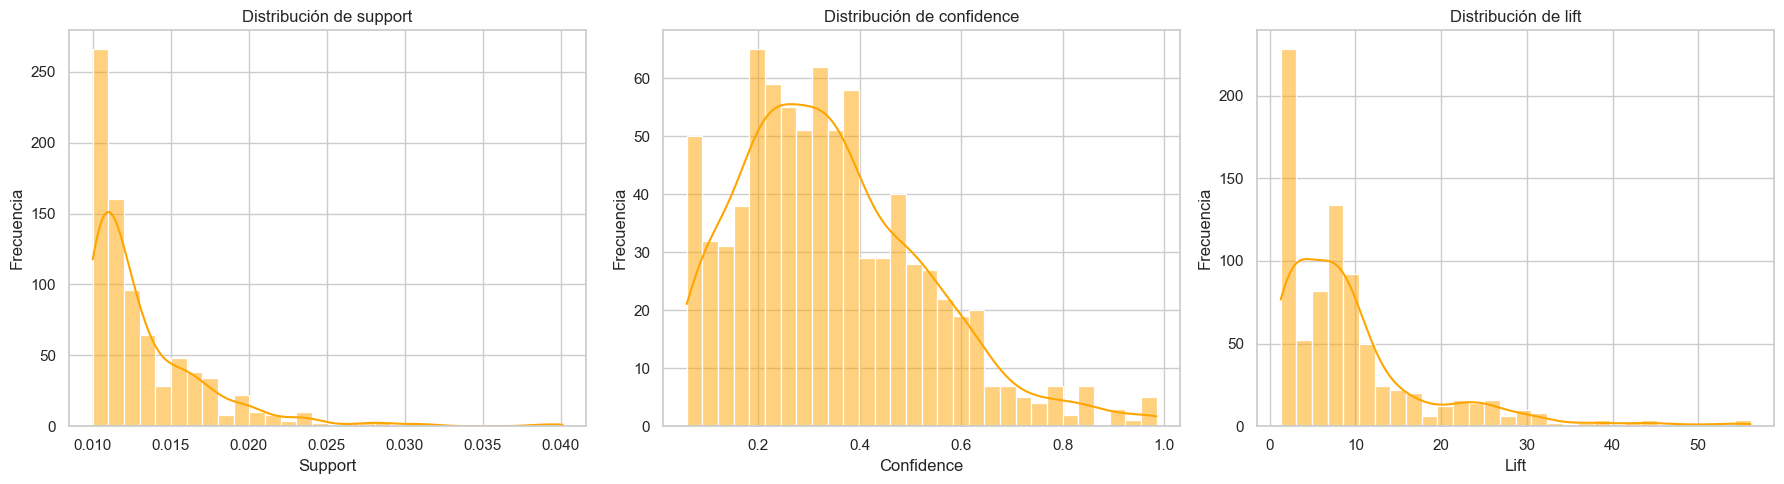

In [11]:
# listo las métricas que quiero visualizar
metricas = ['support', 'confidence', 'lift']

# creo los subplots para visualizar las tres metricas seleccionadas
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, metrica in zip(axes, metricas):
    sns.histplot(df_reglas_uk[metrica], 
                 bins=30, 
                 kde=True, 
                 ax=ax, 
                 color="orange")
    ax.set_title(f'Distribución de {metrica}')
    ax.set_xlabel(metrica.capitalize())
    ax.set_ylabel("Frecuencia")
    ax.grid(True)

plt.tight_layout();

**Interpretación de la distribución de métricas de las reglas**


- `Distribución de support (soporte)`

    - La mayoría de las reglas tienen un soporte **muy bajo**, alrededor de **0.01–0.015**.

    - Prácticamente no hay reglas con soporte superior al 2.5%.

    - Esto indica que las combinaciones de productos **ocurren con baja frecuencia**, aunque suficiente como para ser consideradas interesantes.

    - **Conclusión**: Las reglas encontradas son de tipo *nicho*, no muy frecuentes pero pueden ser útiles si tienen alta confianza o lift.


-  `Distribución de confidence (confianza)`

    - La mayoría de reglas tienen una confianza **moderada** entre **0.2 y 0.5**.

    - Hay pocas reglas realmente fuertes (confianza > 0.8).

    - Esto es habitual en contextos con mucha variabilidad de compra.

    - **Conclusión**: Muchas reglas tienen una fiabilidad razonable, pero conviene centrarse en aquellas con confianza alta si buscamos recomendaciones más seguras.


- `Distribución de lift`

    - La mayoría de reglas tienen un lift entre **1 y 5**.

    - Existen algunos **outliers muy altos**, con valores superiores a 30 o incluso 50.

    - Esto indica que hay algunas asociaciones excepcionalmente fuertes.

    - Las reglas con lift > 1 representan relaciones significativas. Las que tienen lift > 10 o > 30 son ideales para promociones cruzadas o packs de productos.

**Conclusiones generales**

| Métrica     | Observaciones clave                         | Implicaciones                                 |
|-------------|---------------------------------------------|------------------------------------------------|
| **Support**     | Bajo en la mayoría                         | Reglas poco frecuentes → revisión selectiva    |
| **Confidence**  | Concentrado entre 0.2 y 0.5                | Muchas reglas moderadas, pocas muy fiables     |
| **Lift**        | Mayoría entre 1–5, algunos outliers altos  | Asociaciones reales; reglas con lift alto = oro |

## Simulación de Recomendacion

Una vez generadas las reglas de asociación, puedo usarlas para construir un sistema de recomendación. La idea es sencilla: si un usuario añade un producto al carrito, buscamos reglas donde ese producto aparezca como antecedente (lado izquierdo de la regla) y sugerimos el producto que aparece como consecuente (lado derecho).

En esta simulación:

- Buscamos las reglas donde aparece el producto seleccionado como antecedente.

- Ordenamos las reglas por `lift`, que mide la fuerza de la asociación.

- Mostramos los productos recomendados junto con su `confidence` y `lift`.

Esto permite ofrecer **recomendaciones personalizadas y basadas en patrones reales de compra**.

In [12]:
# vamos a hacer una recomendación para un producto
sm.recomendar('WHITE HANGING HEART T-LIGHT HOLDER', df_reglas_uk).head()

consequents  confidence       lift
0  (WOODEN PICTURE FRAME WHITE FINISH)    0.593156  12.184545
1        (WOODEN FRAME ANTIQUE WHITE )    0.688742  11.734717
2     (SWEETHEART CERAMIC TRINKET BOX)    0.525424  10.364628
3     (STRAWBERRY CERAMIC TRINKET BOX)    0.842900  10.312555
4              (HEART OF WICKER SMALL)    0.546512  10.235165

In [13]:
# pruebo a hacer otra recomendacio
sm.recomendar('REGENCY CAKESTAND 3 TIER', df_reglas_uk).head()

consequents  confidence       lift
0    (SWEETHEART CERAMIC TRINKET BOX)    0.673759  13.290721
1    (STRAWBERRY CERAMIC TRINKET BOX)    0.798319   9.767124
2   (GREEN REGENCY TEACUP AND SAUCER)    0.115280   6.496289
3  (ROSES REGENCY TEACUP AND SAUCER )    0.116368   6.312607
4                    (DOTCOM POSTAGE)    0.159326   4.120207

In [14]:
# voy a hacer una recomendacion interactiva

# Extraer todos los productos únicos del lado izquierdo (antecedents)
productos_disponibles = sorted(
    set(
        item
        for conjunto in df_reglas_uk['antecedents']
        for item in conjunto
    )
)

selector_producto = widgets.Dropdown(
    options=productos_disponibles,
    description='Producto:',
    layout=widgets.Layout(width='80%')
)
widgets.interact(
    lambda producto: sm.mostrar_recomendaciones_interactivas(producto, dataframe_reglas=df_reglas_uk),
    producto=selector_producto
)

interactive(children=(Dropdown(description='Producto:', layout=Layout(width='80%'), options=('3 STRIPEY MICE F…

<function __main__.<lambda>(producto)>

## Conclusiones finales del modelo apriori de análisis de cesta (Reino Unido)


- La mayoría de las reglas tienen un **soporte bajo** (poca frecuencia), pero hay un subconjunto con valores de **lift muy elevados**, indicando asociaciones muy fuertes.

- Existen productos que tienden a comprarse **casi siempre juntos**, ideales para promociones cruzadas o bundles.

- El análisis por **tamaño de cesta** muestra que los patrones varían según el volumen de compra.

- El sistema de recomendación permite generar sugerencias personalizadas a partir de productos seleccionados.


**Próximos pasos recomendados**

- **Podría validar reglas en otros países** : Comparar con mercados como Francia, Alemania o Países Bajos para detectar patrones regionales.

- **Podría incorporar más atributos**: Analizar reglas por estacionalidad.

- **Podría probar reglas de mayor longitud** : Explorar combinaciones de más de 2 productos (e.g., reglas 3→1).

- **Podría implementar recomendaciones en producción**: Integrar el sistema en una app de ventas o plataforma de ecommerce.

- **Podría medir impacto**: Si se aplican estas reglas como sugerencias reales, analizar su impacto en conversión o ticket medio.


---

# Modelo *FP-Growth* para UK

El modelo **FP-Growth (Frequent Pattern Growth)** es una alternativa eficiente al algoritmo Apriori para la generación de reglas de asociación. Su objetivo sigue siendo el mismo: descubrir patrones frecuentes en las cestas de compra y generar reglas del tipo:

> *“Si alguien compra el producto A, es probable que también compre el producto B”*.

A diferencia de Apriori, **FP-Growth no necesita generar y evaluar todas las combinaciones posibles** de productos. En lugar de eso, utiliza una estructura de árbol compacta llamada **FP-Tree**, que permite representar las transacciones de forma eficiente sin tener que hacer múltiples pasadas por los datos.

Este modelo es especialmente útil cuando trabajamos con grandes volúmenes de datos, ya que mejora notablemente el rendimiento manteniendo la precisión del análisis.

**¿Cómo funciona *FP-Growth*?**

FP-Growth sigue estos pasos principales:

- **Construcción del FP-Tree**  
  Se escanean las transacciones y se construye un árbol donde cada rama representa una combinación de productos frecuentes. Este árbol compacta la información y permite identificar patrones comunes sin necesidad de generar todas las combinaciones posibles.

- **Extracción de patrones frecuentes**  
  Se recorre el FP-Tree y se generan directamente los conjuntos de productos que aparecen juntos con frecuencia.

- **Generación de reglas de asociación**  
  A partir de estos patrones frecuentes, se generan reglas del tipo *“Si se compra X, también se suele comprar Y”*, evaluadas con métricas como soporte, confianza y lift.

Pongamos un ejemplo para entenderlo mejor. Volviendo al caso del supermercado, si muchas personas compran **pan** y también **mantequilla**, el modelo podría generar la regla:

> Pan → Mantequilla  
> Lo que significa: *“si un cliente compra pan, es probable que también compre mantequilla”*.

La diferencia es que **FP-Growth llegará a esta conclusión de forma más rápida y eficiente**, especialmente cuando hay miles de productos diferentes.

![imagen](../imagenes/funcionamiento-fp-growth-model.png)

In [15]:
df_uk.head(2)

DOORMAT UNION JACK GUNS AND ROSES   3 STRIPEY MICE FELTCRAFT  \
Invoice                                                                   
489434                                 False                      False   
489435                                 False                      False   

          4 PURPLE FLOCK DINNER CANDLES   BANK CHARGES  \
Invoice                                                  
489434                            False          False   
489435                            False          False   

          BLACK PIRATE TREASURE CHEST   BROWN  PIRATE TREASURE CHEST   \
Invoice                                                                 
489434                          False                           False   
489435                          False                           False   

          CAMPHOR WOOD PORTOBELLO MUSHROOM   CHERRY BLOSSOM  DECORATIVE FLASK  \
Invoice                                                                         
489434                               False                              False   
489435                               False                              False   

          FAIRY CAKE CANDLES   FLAMINGO LIGHTS   HOME SWEET HOME  BLACKBOARD  \
Invoice                                                                        
489434                 False             False                         False   
489435                 False             False                         False   

          IVORY PAPER CUP CAKE CASES    LARGE SKULL WINDMILL  \
Invoice                                                        
489434                          False                  False   
489435                          False                  False   

          NEW BAROQUE BLACK BOXES   OVAL WALL MIRROR DIAMANTE   \
Invoice                                                          
489434                      False                        False   
489435                      False                        False   

          PAINT YOUR OWN CANVAS SET   PEACE WOODEN BLOCK LETTERS  \
Invoice                                                            
489434                        False                        False   
489435                        False                        False   

          RED/WHITE DOT MINI CASES   RIDGED GLASS T-LIGHT HOLDER  \
Invoice                                                            
489434                       False                         False   
489435                       False                         False   

          SET 2 TEA TOWELS I LOVE LONDON    SET OF 6 SOLDIER SKITTLES  \
Invoice                                                                 
489434                              False                       False   
489435                              False                       False   

          SILVER CHERRY LIGHTS   SILVER T-LIGHT SETTING  \
Invoice                                                   
489434                   False                    False   
489435                   False                    False   

          STAR  T-LIGHT HOLDER    VINTAGE DESIGN GIFT TAGS  \
Invoice                                                      
489434                    False                      False   
489435                    False                      False   

          WHITE BAMBOO RIBS LAMPSHADE   WHITE CHERRY LIGHTS  \
Invoice                                                       
489434                          False                  True   
489435                          False                 False   

         *BOOMBOX IPOD CLASSIC  *USB OFFICE GLITTER LAMP  \
Invoice                                                    
489434                   False                     False   
489435                   False                     False   

         *USB OFFICE MIRROR BALL  10 COLOUR SPACEBOY PEN  \
Invoice                                                    
489434                     False                   False   
489435           

In [ ]:
# definimos los parametros que podemos ajustar
min_support = 0.01
min_confidence = 0.7

# aplicamos el algoritmo nuevo
frequent_itemsets_fp = fpgrowth(df_uk, 
                                min_support=min_support, # es lo mismo que en el apriori
                                use_colnames=True)

# genero las reglas de asociacion
rules_fp = association_rules(frequent_itemsets_fp, 
                             metric="lift", # igual que en apriori
                             min_threshold=min_confidence) # igual que en apriori

les_fp['antecedents'] = rules_fp['antecedents'].apply(sm.limpiar_nombre)
rules_fp['consequents'] = rules_fp['consequents'].apply(sm.limpiar_nombre)

# muestro el resumen de los resultados
print(f"🔍 Reglas generadas con FP-Growth: {rules_fp.shape[0]}")
display(rules_fp[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head(10))

🔍 Reglas generadas con FP-Growth: 814


antecedents                       consequents  \
798     poppy's playhouse livingroom         poppy's playhouse bedroom    
799        poppy's playhouse bedroom      poppy's playhouse livingroom    
796         poppy's playhouse kitchen     poppy's playhouse livingroom    
797     poppy's playhouse livingroom          poppy's playhouse kitchen   
794         poppy's playhouse kitchen        poppy's playhouse bedroom    
795        poppy's playhouse bedroom          poppy's playhouse kitchen   
772    pink regency teacup and saucer   green regency teacup and saucer   
773   green regency teacup and saucer    pink regency teacup and saucer   
404  set/10 blue spotty party candles  set/10 pink spotty party candles   
405  set/10 pink spotty party candles  set/10 blue spotty party candles   

      support  confidence       lift  
798  0.010700    0.855932  56.105167  
799  0.010700    0.701389  56.105167  
796  0.011283    0.682692  54.609599  
797  0.011283    0.902542  54.609599  
794  0.013137    0.794872  52.102742  
795  0.013137    0.861111  52.102742  
772  0.010753    0.852941  48.065145  
773  0.010753    0.605970  48.065145  
404  0.011442    0.797048  44.648877  
405  0.011442    0.640950  44.648877